# A 4 bit quantization transform for Thunder


In this notebook, we will implement a seamless 4 bit quantization transform for thunder.
We will use `bitsandbytes`for the 4 bit quantization and kernel.

First let's import.

In [1]:
import bitsandbytes
import thunder
import torch

To have something concrete to work with, let's take [LitGPT](https://github.com/Lightning-AI/litgpt)'s quantized generation:

In [2]:
from lightning import fabric
from lightning.fabric.plugins import BitsandbytesPrecision


In [3]:
# Copyright Lightning AI. Licensed under the Apache License 2.0, see LICENSE file.

import sys
import time
from pathlib import Path
from typing import Any, Literal, Optional

import lightning as L
import torch
import torch._dynamo.config
import torch._inductor.config
from lightning.fabric.plugins import BitsandbytesPrecision

from litgpt import GPT, Config, PromptStyle, Tokenizer
from litgpt.prompts import has_prompt_style, load_prompt_style
from litgpt.utils import CLI, check_valid_checkpoint_dir, get_default_supported_precision, load_checkpoint



def multinomial_num_samples_1(probs: torch.Tensor) -> torch.Tensor:
    if torch._dynamo.is_compiling():
        # Faster alternative to `torch.multinomial(probs, num_samples=1)` that is also CUDAGraph friendly
        distribution = torch.empty_like(probs).exponential_(1)
        return torch.argmax(probs / distribution, dim=-1, keepdim=True)
    return torch.multinomial(probs, num_samples=1)


def sample_top_p(logits: torch.Tensor, top_p: float) -> torch.Tensor:
    sorted_logits, sorted_indices = torch.sort(logits, descending=False)
    cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
    # Example:
    # sorted_probs=[0.1, 0.15, 0.2, 0.25, 0.3] -> sorted_cumprobs=[0.1, 0.25, 0.45, 0.7, 1.0]
    # sorted_indices_to_remove = [1, 1, 0, 0, 0] if top_p=0.7
    sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
    # Keep at least 1 token always to prevent the case where no token is selected
    # In this case the most probable one is always kept
    sorted_indices_to_remove[-1:] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
    logits = logits.masked_fill(indices_to_remove, float("-inf"))
    return logits


def sample(
    logits: torch.Tensor, temperature: float = 1.0, top_k: Optional[int] = None, top_p: float = 1.0
) -> torch.Tensor:
    if top_p < 0.0 or top_p > 1.0:
        raise ValueError(f"top_p must be in [0, 1], got {top_p}")
    logits = logits[0, -1]
    # optionally crop the logits to only the top k options
    if top_k is not None:
        v, i = torch.topk(logits, min(top_k, logits.size(-1)))
        # do not use `torch.where` as in nanogpt because it will repeat top-k collisions
        logits = torch.full_like(logits, float("-inf")).scatter_(-1, i, v)
    # optionally scale the logits and sample from a probability distribution
    if temperature > 0.0 or top_p > 0.0:
        if temperature > 0.0:
            logits = logits / temperature
        # optionally crop the logits to smallest set of logits with a cumulative probability above top_p
        if top_p < 1.0:
            logits = sample_top_p(logits, top_p)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        return multinomial_num_samples_1(probs)
    return torch.argmax(logits, dim=-1, keepdim=True)


def next_token(model: GPT, input_pos: torch.Tensor, x: torch.Tensor, **kwargs: Any) -> torch.Tensor:
    logits = model(x, input_pos)
    next = sample(logits, **kwargs)
    return next.to(dtype=x.dtype)


@torch.inference_mode()
def generate(
    model: GPT,
    prompt: torch.Tensor,
    max_returned_tokens: int,
    *,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: float = 1.0,
    eos_id: Optional[int] = None,
) -> torch.Tensor:
    """Takes a conditioning sequence (prompt) as input and continues to generate as many tokens as requested.

    The implementation of this function is modified from A. Karpathy's nanoGPT.

    Args:
        model: The model to use.
        prompt: Tensor of shape (T) with indices of the prompt sequence.
        max_returned_tokens: The maximum number of tokens to return (given plus generated).
        temperature: Scales the predicted logits by 1 / temperature.
        top_k: If specified, only sample among the tokens with the k highest probabilities.
        top_p: If specified, it represents the cumulative probability threshold to consider in the sampling process.
            In top-p sampling, the next token is sampled from the highest probability tokens
            whose cumulative probability exceeds the threshold `top_p`. When specified,
            it must be `0 <= top_p <= 1`. Here, `top_p=0` is equivalent
            to sampling the most probable token, while `top_p=1` samples from the whole distribution.
            It can be used in conjunction with `top_k` and `temperature` with the following order
            of application:

            1. `top_k` sampling
            2. `temperature` scaling
            3. `top_p` sampling

            For more details, see https://arxiv.org/abs/1904.09751
            or https://huyenchip.com/2024/01/16/sampling.html#top_p
        eos_id: If specified, stop generating any more token once the <eos> token is triggered.
    """
    T = prompt.size(0)
    assert max_returned_tokens > T
    if model.max_seq_length < max_returned_tokens - 1:
        # rolling the kv cache based on the `input_pos` value would be necessary. However, doing so would introduce a
        # data dependency on the `input_pos` tensor and impact model compilation. Since this setting is uncommon, we do
        # not support it to avoid negatively impacting the overall speed
        raise NotImplementedError(f"max_seq_length {model.max_seq_length} needs to be >= {max_returned_tokens - 1}")

    device = prompt.device
    tokens = [prompt]
    input_pos = torch.tensor([T], device=device)
    token = next_token(
        model, torch.arange(0, T, device=device), prompt.view(1, -1), temperature=temperature, top_k=top_k, top_p=top_p
    ).clone()
    tokens.append(token)
    for _ in range(2, max_returned_tokens - T + 1):
        token = next_token(
            model, input_pos, token.view(1, -1), temperature=temperature, top_k=top_k, top_p=top_p
        ).clone()
        tokens.append(token)
        if token == eos_id:
            break
        input_pos = input_pos.add_(1)
    return torch.cat(tokens)


with torch.inference_mode():
    prompt: str = "What food do llamas eat? Answer in German."
    num_samples: int = 1
    max_new_tokens: int = 256
    top_k: Optional[int] = 50
    top_p: float = 1.0
    temperature: float = 0.8
    checkpoint_dir: Path = Path("/home/tv/data/firma/grid/thunder/litgpt/checkpoints/meta-llama/Meta-Llama-3-8B-Instruct/")
    quantize: Optional[Literal["bnb.nf4", "bnb.nf4-dq", "bnb.fp4", "bnb.fp4-dq", "bnb.int8"]] = "bnb.nf4"
    precision: Optional[str] = "bf16-true"
    compile: bool = False
# litgpt generate base --quantize bnb.nf4 --checkpoint_dir checkpoints/tiiuae/falcon-7b --precision bf16-true --max_new_tokens 256

    """Generates text samples based on a pre-trained model and tokenizer.

    Args:
        prompt: The prompt string to use for generating the samples.
        num_samples: The number of text samples to generate.
        max_new_tokens: The number of generation steps to take.
        top_k: The number of top most probable tokens to consider in the sampling process.
        top_p: If specified, it represents the cumulative probability threshold to consider in the sampling process.
            In top-p sampling, the next token is sampled from the highest probability tokens
            whose cumulative probability exceeds the threshold `top_p`. When specified,
            it must be `0 <= top_p <= 1`. Here, `top_p=0` is equivalent
            to sampling the most probable token, while `top_p=1` samples from the whole distribution.
            It can be used in conjunction with `top_k` and `temperature` with the following order
            of application:

            1. `top_k` sampling
            2. `temperature` scaling
            3. `top_p` sampling

            For more details, see https://arxiv.org/abs/1904.09751
            or https://huyenchip.com/2024/01/16/sampling.html#top_p
        temperature: A value controlling the randomness of the sampling process. Higher values result in more random
            samples.
        checkpoint_dir: The checkpoint directory to load.
        quantize: Whether to quantize the model and using which method:
            - bnb.nf4, bnb.nf4-dq, bnb.fp4, bnb.fp4-dq: 4-bit quantization from bitsandbytes
            - bnb.int8: 8-bit quantization from bitsandbytes
            for more details, see https://github.com/Lightning-AI/litgpt/blob/main/tutorials/quantize.md
        precision: Indicates the Fabric precision setting to use.
        compile: Whether to compile the model.
    """
    precision = precision or get_default_supported_precision(training=False)

    plugins = BitsandbytesPrecision(mode='nf4', dtype=torch.bfloat16)
    precision = None

    fabric = L.Fabric(devices=1, precision=precision, plugins=plugins)

    check_valid_checkpoint_dir(checkpoint_dir)
    config = Config.from_file(checkpoint_dir / "model_config.yaml")

    checkpoint_path = checkpoint_dir / "lit_model.pth"

    tokenizer = Tokenizer(checkpoint_dir)
    prompt_style = (
        load_prompt_style(checkpoint_dir) if has_prompt_style(checkpoint_dir) else PromptStyle.from_config(config)
    )

    prompt = prompt_style.apply(prompt)
    encoded = tokenizer.encode(prompt, device=fabric.device)
    prompt_length = encoded.size(0)
    max_returned_tokens = prompt_length + max_new_tokens

    fabric.print(f"Loading model {str(checkpoint_path)!r} with {config.__dict__}", file=sys.stderr)
    t0 = time.perf_counter()
    with fabric.init_module(empty_init=True):
        model = GPT(config)
    fabric.print(f"Time to instantiate model: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)
    with fabric.init_tensor():
        # set the max_seq_length to limit the memory usage to what we need
        model.max_seq_length = max_returned_tokens
        # enable the kv cache
        model.set_kv_cache(batch_size=1)
    model.eval()

    if compile:
        torch._dynamo.config.automatic_dynamic_shapes = True
        torch._inductor.config.triton.unique_kernel_names = True
        torch._inductor.config.coordinate_descent_tuning = True
        global next_token
        next_token = torch.compile(next_token, mode="reduce-overhead")

    model = fabric.setup_module(model)

    t0 = time.perf_counter()
    load_checkpoint(fabric, model, checkpoint_path)
    fabric.print(f"Time to load the model weights: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)

    L.seed_everything(1234)
    for i in range(num_samples):
        t0 = time.perf_counter()
        y = generate(model, encoded, max_returned_tokens, temperature=temperature, top_k=top_k, top_p=top_p, eos_id=tokenizer.eos_id)
        t = time.perf_counter() - t0
        for block in model.transformer.h:
            block.attn.kv_cache.reset_parameters()
        fabric.print(tokenizer.decode(y))
        tokens_generated = y.size(0) - prompt_length
        fabric.print(
            f"Time for inference {i + 1}: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr
        )
    if fabric.device.type == "cuda":
        fabric.print(f"Memory used: {torch.cuda.max_memory_allocated() / 1e9:.02f} GB", file=sys.stderr)


Loading model '/home/tv/data/firma/grid/thunder/litgpt/checkpoints/meta-llama/Meta-Llama-3-8B-Instruct/lit_model.pth' with {'name': 'Llama-3-8B-Instruct', 'hf_config': {'name': 'Meta-Llama-3-8B-Instruct', 'org': 'meta-llama'}, 'scale_embeddings': False, 'block_size': 8192, 'vocab_size': 128000, 'padding_multiple': 512, 'padded_vocab_size': 128256, 'n_layer': 32, 'n_head': 32, 'head_size': 128, 'n_embd': 4096, 'rotary_percentage': 1.0, 'parallel_residual': False, 'bias': False, 'lm_head_bias': False, 'n_query_groups': 8, 'shared_attention_norm': False, 'norm_class_name': 'RMSNorm', 'norm_eps': 1e-05, 'mlp_class_name': 'LLaMAMLP', 'gelu_approximate': 'none', 'intermediate_size': 14336, 'rope_condense_ratio': 1, 'rope_base': 500000, 'n_expert': 0, 'n_expert_per_token': 0, 'rope_n_elem': 128}
Time to instantiate model: 0.22 seconds.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('me

system

You are a helpful assistant.
user

What food do llamas eat? Answer in German.
assistant

Die Lamas fressen Gräser und Pflanzen, insbesondere Gras, Blätter, Triebe und Blumen. Sie sind Omnivoren und können auch Obst und Getreide konsumieren, wenn es ihnen zur Verfügung steht.


Time for inference 1: 1.49 sec total, 37.47 tokens/sec
Memory used: 7.57 GB


# Excursion: How does quantization work

To take a detailed look at how quantization works, let's see how the quantization works. First we quantize to 4 bit using `quantize_4bit`. It returns a quantized tensor and a status object.

In [4]:
w = torch.randn(200, 100, device="cuda")
qt, st = bitsandbytes.functional.quantize_4bit(w, quant_type='nf4')

Then we can use `matmul_4bit` to multiply a (floating-point) activation with the quantized amtrix.

In [5]:
x = torch.randn(300, 100, device="cuda")
out = bitsandbytes.matmul_4bit(x, qt.t(), bias=None, quant_state=st)


We can compare the quantized matmul to the original floating point one. There is quite a difference (due to 4 bits not being very precise)...

In [6]:
(out - x @ w.t()).abs().mean()

tensor(0.7309, device='cuda:0')

...but when comparing to the magnitude of the result, we see that everything is good.

In [7]:
out.abs().mean()

tensor(7.9811, device='cuda:0')

But so how does it work?

Let's re-do the `matmul_4bit` manually in PyTorch.

The quantized tensor is a `uint8` tensor, each byte in the tensor encodes two 4-bit-entries in the original matrix. The tensor has been flattened.

In [8]:
qt

tensor([[ 90],
        [ 37],
        [102],
        ...,
        [107],
        [136],
        [180]], device='cuda:0', dtype=torch.uint8)

The quantization state that has been returned by `quantize_4bit` contains the information to dequantize:

In [9]:
st

Key properties of the quantization state are

- `.blocksize` defines the blocksize, values within a block share the same scale from `.absmax`.
- `.code` is a "dictionary" to index into with the 4 bit value `0` ... `15`. The code seems to be normalized to the range -1 ... 1 and is not equidistributed.
- `.absmax` contains scales for all blocks (of size `.blocksize`),
- `.dtype` is the original dtype,
- `.shape` is the original shape.

We can look at the `.code` dictionary:

tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
         0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
       device='cuda:0')


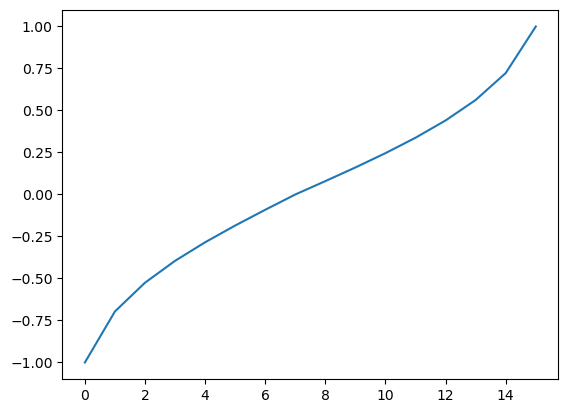

In [10]:
print(st.code)
from matplotlib import pyplot
pyplot.plot(st.code.cpu())

And we can decode the tensor:

In [11]:
w_dequant = torch.stack((st.code[(qt.squeeze().int() >> 4) & 0xf], st.code[qt.squeeze().int() & 0xf]), -1).view(-1)
for i, m in zip(range(0, w_dequant.size(0), st.blocksize), st.absmax):
    w_dequant[i: i + st.blocksize] *= m
    
w_dequant = w_dequant.view(st.shape)

We can see whether the output computed by `matmul_4bit` with a matrix multiplication with our manually dequantized matrix:

In [12]:
out - x @ w_dequant.t()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

## 4 bit matmul in Thunder

But now, let's get the 4 bit matmul into Thunder.
Happily, Thunder is easily extensible, so we can just define a nf8 meta and implementation, instantiate an `OperatorExecutor` and register our new symbol.

In [13]:
from typing import Sequence

In [14]:
import thunder
ex = thunder.extend.OperatorExecutor('quant_bnb', version=0.1)

In [15]:
def bnb_matmul_nf4_meta(x, qweight, bias, absmax, quant_map, blocksize, dtype, shape):
    assert isinstance(shape, Sequence) and len(shape) == 2
    assert x.shape[-1] == shape[1], f"{x.shape=}, rhs {shape=}"
    return thunder.TensorProxy(like=x, shape=(*x.shape[:-1], shape[0]))

def bnb_matmul_nf4_impl(x, qweight, bias, absmax, quant_map, blocksize, dtype, shape):
    qs = bitsandbytes.functional.QuantState(absmax, shape=shape, blocksize=blocksize, code=quant_map,
                                            quant_type='nf4', dtype=dtype)
    
    return bitsandbytes.matmul_4bit(x, qweight.t(), bias=bias, quant_state=qs)

In [16]:
bnb_matmul_nf4 = ex.register_operator('bnb_matmul_nf4', meta=bnb_matmul_nf4_meta, fn=bnb_matmul_nf4_impl)

In [17]:
bnb_matmul_nf4

[Symbol name=bnb_matmul_nf4]

Let's try this on a function:

In [18]:
def fn(x, qweight, qs):
    return bnb_matmul_nf4(x, qweight, None, qs.absmax, qs.code, qs.blocksize, qs.dtype, qs.shape)

In [19]:
jfn = thunder.jit(fn)

In [20]:
jfn(x, qt, st)

tensor([[ -5.6017,  -6.9423,  14.8765,  ...,   6.7327,  -0.9416, -13.1131],
        [ 11.6984,  -1.3968,  -1.5242,  ...,   5.7076,  -5.6656,  -7.5721],
        [ -7.2364,   0.3612,   4.7494,  ...,  13.5308,  12.4456,  16.8248],
        ...,
        [ 19.8676,  13.6140, -17.0503,  ...,  -6.3070,   4.9783,  -0.5094],
        [-17.1213,  -5.3133, -22.2789,  ...,   2.8354,   2.1703,  -8.1751],
        [  8.0881,   8.1432,  -5.1421,  ...,  -7.8354,   3.0699,  -8.4743]],
       device='cuda:0')

In [21]:
thunder.last_traces(jfn)[0]

import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
def computation(x, qweight, t_2_absmax, t_2_code):
  # x: "cuda:0 f32[300, 100]"
  # qweight: "cuda:0 ui8[10000, 1]"
  # t_2_absmax: "cuda:0 f32[313]"
  # t_2_code: "cuda:0 f32[16]"

  # /tmp/ipykernel_1517946/3597101269.py:2: 	    return bnb_matmul_nf4(x, qweight, None, qs.absmax, qs.code, qs.blocksize, qs.dtype, qs.shape)
  t3 = bnb_matmul_nf4(x, qweight, None, t_2_absmax, t_2_code, 64, torch.float32, (200, 100))  # t3: "cuda:0 f32[300, 200]"
  return t3

## Quantizing a model

In [22]:
import torch, thunder, bitsandbytes

In [23]:
#qt, st = bitsandbytes.functional.quantize_4bit(tm, , quant_type='nf4')

In [24]:
m = torch.nn.Sequential(
    torch.nn.Linear(128, 256, bias=False),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128, bias=False)
).cuda()
tm = thunder.jit(m)
a = torch.randn(4, 128, device='cuda')
tm(a);
computation_trace = thunder.last_traces(tm)[0]
prologue_trace = thunder.last_prologue_traces(tm)[0]
prologue_trace, computation_trace

(import thunder
 import thunder.core.prims as prims
 import torch
 from thunder.executors.torchex import no_autocast
 
 @torch.no_grad()
 @no_autocast
 def prologue(*args, **kwargs):
   # args: "Any"
   prims.check_len(args, 1)
   # kwargs: "Any"
   prims.check_len(kwargs, 0)
   input: "cuda:0 f32[4, 128]" = args[0]
   p0: "Any" = globals()['__function_obj']
   module: "Any" = thunder.core.module.get_thunder_module(p0)
   t_0_weight: "cuda:0 f32[256, 128]" = module.get_parameter('0.weight')
   t_2_weight: "cuda:0 f32[128, 256]" = module.get_parameter('2.weight')
   prims.check_tensor_metadata(input, (4, 128), 'cuda:0', torch.float32, False)
   m: "Any" = module.get_submodule('0')
   b0: "bool True" = m.training
   prims.check_number_type_and_value(b0, True)
   i1: "int 128" = m.in_features
   prims.check_number_type_and_value(i1, 128)
   i2: "int 256" = m.out_features
   prims.check_number_type_and_value(i2, 256)
   prims.check_tensor_metadata(t_0_weight, (256, 128), 'cuda:0', torch.fl

In [25]:
from thunder.core.transform_common import EarlyTransform

class LinearQuant4bit(EarlyTransform):
    def __init__(self):
        self.quant_states = {}

    def transform_module(self, model: thunder.ThunderModule):
        def convert_linear_submodule(tm, name):    
            weight_name = f"{name}.weight"
            w = tm.get_parameter(weight_name)
            # device!
            qw, qs = bitsandbytes.functional.quantize_4bit(w.to('cuda'), quant_type='nf4')
            tm._overrides_parameters[weight_name] = qw
            tm._overrides_parameters[f"{weight_name}.absmax"] = qs.absmax
            tm._overrides_parameters[f"{weight_name}.code"] = qs.code
            self.quant_states[weight_name] = {'dtype': qs.dtype, 'shape': qs.shape, 'blocksize': qs.blocksize}

        for n, submodule in model._model.named_modules():
            if isinstance(submodule, torch.nn.Linear):
                convert_linear_submodule(model, n)

    def transform_traces(self, prologue_trace, computation_trace, epilogue_trace, **kwargs):
        from thunder.core.trace import tracectx
        def get_orig_and_thunder_module_proxies_from_prologue(prologue_trace): 
            modules_and_thunder_modules = [
                (bsym.args[0], bsym.output)
                for bsym in prologue_trace.bound_symbols
                if bsym.sym is prims.unpack_thunder_module
            ]

            if len(modules_and_thunder_modules) != 1:
                raise NotImplementedError("cannot deal with modules other than the compiled module")

            ((orig_module_proxy, thunder_module_proxy),) = modules_and_thunder_modules
            if prologue_producers[orig_module_proxy].sym is not prims.unpack_function_obj:
                raise NotImplementedError("original module does not match the compiled module")

            return orig_module_proxy, thunder_module_proxy

        from thunder.core import utils
        from thunder.core import prims

        def get_checks(prologue_trace):
            check_dict = {}
            prologue_producers, prologue_consumers = utils.producers_and_consumers(prologue_trace)
            for bsym in prologue_trace.bound_symbols:
                if bsym.sym == prims.unpack_parameter or bsym.sym == prims.unpack_buffer:
                    param_thunder_module, param_name = bsym.args
                    checks = [bsym2 for bsym2 in prologue_consumers[bsym.output] if bsym2.sym == prims.check_tensor_shape_and_metadata]
                    assert len(checks) == 1, f"expected each parameter and buffer to have exactly one checker, but {bsym.output} has {len(checks)}"
                    assert isinstance(param_name, str)
                    check_dict[param_name] = (checks[0], bsym)
            return check_dict

        def add_trace_output(trace, output):
            ret_node = trace.bound_symbols[-1]
            assert ret_node.sym == prims.python_return
            assert len(ret_node.args) == 1
            ret_node.args = ((*ret_node.args[0], output),)


        checks = get_checks(prologue_trace)

        compute_producers, compute_consumers = utils.producers_and_consumers(computation_trace)

        output_idxes = {id(o): i for i, o in enumerate(prologue_trace.output)}

        computation_trace.push_scope([])
        quantized_proxies : dict[int, str]= {}  # id -> name

        new_bsyms = []
        new_compute_inputs = []
        for n, qs in self.quant_states.items():
            param = tm.get_parameter(n)
            n_absmax = f"{n}.absmax"
            n_code = f"{n}.code"
            param_absmax = tm.get_parameter(n_absmax)
            param_code = tm.get_parameter(n_code)
            check, get_param = checks[n]
            quantized_proxies[id(get_param.output)] = n
            # check has args: tensor, shape, device, dtype, requires_grad
            proxy, _, _, _, requires_grad = check.args
            thunder_device = thunder.devices.to_device(param.device)
            thunder_device_str = str(thunder_device)
            check.args = (proxy, (*param.shape,), thunder_device_str, param.dtype, False) 

            output_idx = output_idxes.get(id(get_param.output))
            if output_idx is not None:
                with tracectx(prologue_trace):
                    # better way
                    proxy_absmax = thunder.TensorProxy(name=f"{get_param.output.name}_absmax",
                                                 shape=param_absmax.shape, dtype=thunder.dtypes.to_dtype(param_absmax.dtype),
                                                 device=thunder.devices.to_device(param_absmax.device), requires_grad=False)
                    proxy_code = thunder.TensorProxy(name=f"{get_param.output.name}_code",
                                                 shape=param_code.shape, dtype=thunder.dtypes.to_dtype(param_code.dtype),
                                                 device=thunder.devices.to_device(param_code.device), requires_grad=False)
                    # get_param.sym = unpack_buffer/parameter as needed
                    new_bsyms.append(get_param.sym.bind(get_param.args[0], n_absmax, output=proxy_absmax))
                    new_bsyms.append(get_param.sym.bind(get_param.args[0], n_code, output=proxy_code))
                    add_trace_output(prologue_trace, proxy_absmax)
                    add_trace_output(prologue_trace, proxy_code)
                    new_compute_inputs.append(proxy_absmax)
                    new_compute_inputs.append(proxy_code)
                    qs['proxy_absmax'] = proxy_absmax
                    qs['proxy_code'] = proxy_code
                compute_input = computation_trace.args[output_idx]

        prologue_trace.bound_symbols[-1:-1] = new_bsyms


        with tracectx(computation_trace):
            new_bindings = [thunder.core.prims.unpack_trivial.bind(i, output=i) for i in new_compute_inputs]

        new_computation_trace = thunder.core.trace.from_trace(computation_trace)
        new_computation_trace.args = (*new_computation_trace.args, *new_compute_inputs)
        new_computation_trace._siginfo.args = [(a.name, None) for a in new_computation_trace.args]
        for idx, bsym in enumerate(computation_trace.bound_symbols):
            if bsym.sym != prims.unpack_trivial:
                break
            new_computation_trace.bound_symbols.append(bsym.from_bsym())
        new_computation_trace.bound_symbols += new_bindings
        proxies_to_replace = {}
        for bsym in computation_trace.bound_symbols[idx:]:
            if bsym.sym == thunder.torch.linear and id(bsym.args[1]) in quantized_proxies:
                assert len(bsym.args) == 3 # torch.linear(input, weight, bias) 
                n = quantized_proxies[id(bsym.args[1])]
                qs = self.quant_states[n]
                # bnb_matmul_nf4(x, qweight, bias, absmax, quant_map, blocksize, dtype, shape)
                #  how to replace the _call_ctx(???)
                new_args = (*bsym.args[:3], qs['proxy_absmax'], qs['proxy_code'], qs['blocksize'], qs['dtype'], qs['shape'])
                new_computation_trace.bound_symbols.append(bsym.from_bsym(sym=bnb_matmul_nf4,
                                                                          _call_ctx={'bnb_matmul_nf4': bnb_matmul_nf4_impl}, 
                                                                          subsymbols=[], args=new_args))
            else:
                new_computation_trace.bound_symbols.append(bsym.from_bsym())

        new_computation_trace.set_provenance(thunder.core.trace.TraceProvenance("quant pass"))
        return prologue_trace, new_computation_trace, epilogue_trace


In [26]:
a = torch.randn(4, 128, device='cuda')

expected = m(a)

tm = thunder.jit(m, executors=(ex, *thunder.get_default_executors()))

transform = LinearQuant4bit()
transform.transform_module(tm)
tm2 = thunder.core.transforms.add_transform(tm, early_transform=transform)

actual = tm2(a)

In [27]:
thunder.last_traces(tm2)[1]

# Constructed by quant pass
import thunder
import thunder.torch as ltorch
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
def computation(input, t_0_weight, t_2_weight, t_0_weight_absmax, t_0_weight_code, t_2_weight_absmax, t_2_weight_code):
  # input: "cuda:0 f32[4, 128]"
  # t_0_weight: "cuda:0 f32[256, 128]"
  # t_2_weight: "cuda:0 f32[128, 256]"
  # t_0_weight_absmax: "cuda:0 f32[512]"
  # t_0_weight_code: "cuda:0 f32[16]"
  # t_2_weight_absmax: "cuda:0 f32[512]"
  # t_2_weight_code: "cuda:0 f32[16]"

  # /usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:116: 	        return F.linear(input, self.weight, self.bias)
  t3 = bnb_matmul_nf4(input, t_0_weight, None, t_0_weight_absmax, t_0_weight_code, 64, torch.float32, (256, 128))  # t3: "cuda:0 f32[4, 256]"

  # /usr/local/lib/python3.11/dist-packages/torch/nn/modules/activation.py:696: 	        return F.gelu(input, approximate=self.approximate)
  t9 = ltorch.gelu(t3, appro